# General data reader for AQUA 
## Time averaging

Input data may not be available at the desired time frequency. It is possible to perform time averaging at a given frequency (currently daily and monthly are implemented) using the `timmean()` method of the reader. It would in theory be possible also to specify averaging already when instantiating the reader, but this may not be the most efficient choice.

In [1]:
from aqua import Reader

Here we demonstrate the functionality for sample IFS data which at the same time are also regridded to a desired 1°x1° grid. We specify the regridding frequency with the `freq` keyword. 

In [2]:
reader = Reader(model="IFS", exp="tco2559-ng5", source="ICMGG_atm2d", freq='daily', regrid="r100", fix=False)
data = reader.retrieve()
data

2023-07-19 15:53:42 :: Reader :: WARNING  -> Weights file not found: /work/bb1153/b382075/nextgems/weights/weights_IFS_tco2559-ng5_ICMGG_atm2d_ycon_r100_l2dm.nc
2023-07-19 15:53:42 :: Reader :: WARNING  -> Attempting to generate it ...
2023-07-19 15:56:41 :: Reader :: WARNING  -> Success!


<xarray.Dataset>
Dimensions:  (time: 8329, value: 26306560, level: 5)
Coordinates:
    lat      (value) float64 dask.array<chunksize=(26306560,), meta=np.ndarray>
  * level    (level) int64 1 2 3 4 5
    lon      (value) float64 dask.array<chunksize=(26306560,), meta=np.ndarray>
  * time     (time) datetime64[ns] 2020-01-20 2020-01-20T01:00:00 ... 2021-01-01
Dimensions without coordinates: value
Data variables: (12/81)
    100si    (time, value) float64 dask.array<chunksize=(1, 26306560), meta=np.ndarray>
    100u     (time, value) float64 dask.array<chunksize=(1, 26306560), meta=np.ndarray>
    100v     (time, value) float64 dask.array<chunksize=(1, 26306560), meta=np.ndarray>
    10u      (time, value) float64 dask.array<chunksize=(1, 26306560), meta=np.ndarray>
    10v      (time, value) float64 dask.array<chunksize=(1, 26306560), meta=np.ndarray>
    2d       (time, value) float64 dask.array<chunksize=(1, 26306560), meta=np.ndarray>
    ...       ...
    uvb      (time, value) float64 dask.array<chunksize=(1, 26306560), meta=np.ndarray>
    vike     (time, value) float64 dask.array<chunksize=(1, 26306560), meta=np.ndarray>
    vipie    (time, value) float64 dask.array<chunksize=(1, 26306560), meta=np.ndarray>
    vipile   (time, value) float64 dask.array<chunksize=(1, 26306560), meta=np.ndarray>
    vithe    (time, value) float64 dask.array<chunksize=(1, 26306560), meta=np.ndarray>
    z        (time, value) float64 dask.array<chunksize=(1, 26306560), meta=np.ndarray>
Attributes:
    edition:            1
    centre:             ecmf
    centreDescription:  European Centre for Medium-Range Weather Forecasts
    subCentre:          0
    history:            🪄🧙‍♂️🔮 magic dataset assembly provided by gribscan.IF...

These data are still at the original (hourly) frequency. Let's time average just the surface temperatures (the original data in this case):

In [4]:
daily = reader.timmean(data['2t'])
daily

<xarray.DataArray '2t' (time: 348, value: 26306560)>
dask.array<stack, shape=(348, 26306560), dtype=float64, chunksize=(1, 26306560), chunktype=numpy.ndarray>
Coordinates:
    lat      (value) float64 dask.array<chunksize=(26306560,), meta=np.ndarray>
    lon      (value) float64 dask.array<chunksize=(26306560,), meta=np.ndarray>
  * time     (time) datetime64[ns] 2020-01-20 2020-01-21 ... 2021-01-01
Dimensions without coordinates: value
Attributes: (12/16)
    paramId:                    167
    dataType:                   fc
    numberOfPoints:             26306560
    typeOfLevel:                surface
    stepUnits:                  1
    stepType:                   instant
    ...                         ...
    cfVarName:                  t2m
    missingValue:               9999
    totalNumber:                0
    NV:                         0
    gridDefinitionDescription:  Gaussian Latitude/Longitude Grid
    history:                    2023-07-19 15:56:57 resampled to frequency 1D...

Data have now been averaged at the daily timescale. We can proceed and regrid them

In [5]:
tas = reader.regrid(daily[2,:])
tas

<xarray.DataArray '2t' (lat: 180, lon: 360)>
dask.array<reshape, shape=(180, 360), dtype=float64, chunksize=(180, 360), chunktype=numpy.ndarray>
Coordinates:
    time     datetime64[ns] 2020-01-22
  * lat      (lat) float64 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
  * lon      (lon) float64 0.0 1.0 2.0 3.0 4.0 ... 355.0 356.0 357.0 358.0 359.0
Attributes: (12/17)
    paramId:                    167
    dataType:                   fc
    numberOfPoints:             26306560
    typeOfLevel:                surface
    stepUnits:                  1
    stepType:                   instant
    ...                         ...
    missingValue:               9999
    totalNumber:                0
    NV:                         0
    gridDefinitionDescription:  Gaussian Latitude/Longitude Grid
    history:                    2023-07-19 15:56:57 resampled to frequency 1D...
    regridded:                  1

And we call the plot. This might takes a bit of time, since the files need to be loaded. Dask should be reasonably efficient calling only the frames that we need to create the time averaging. 

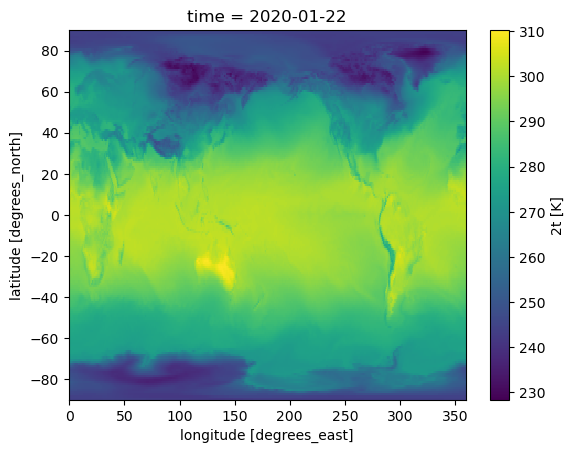

In [6]:
tas.plot()

Notice: You could ask to regrid data by specifying the argument `timmean=True` and `regrid=True` to the retrieve method when reading the data, but please be warned that without a selection on dates this will take longer. It is usually more efficient to first load the data, select, average and then regrid. The option `regrid=True` for the reader will make sense probably for streamed data, if you know that you will want to regrid all of the input xarray anyway. The regridding is applied to a dask DataArray, so execution is delayed and one can select variables and periods of interest later, but still, it takes longer by asking to regrid everything at this stage.

In [7]:
reader = Reader(model="IFS", exp="tco2559-ng5", source="ICMGG_atm2d", freq='daily', fix=False)
data = reader.retrieve(timmean=True)
data

<xarray.Dataset>
Dimensions:  (time: 348, value: 26306560, level: 5)
Coordinates:
    lat      (value) float64 dask.array<chunksize=(26306560,), meta=np.ndarray>
  * level    (level) int64 1 2 3 4 5
    lon      (value) float64 dask.array<chunksize=(26306560,), meta=np.ndarray>
  * time     (time) datetime64[ns] 2020-01-20 2020-01-21 ... 2021-01-01
Dimensions without coordinates: value
Data variables: (12/81)
    100si    (time, value) float64 dask.array<chunksize=(1, 26306560), meta=np.ndarray>
    100u     (time, value) float64 dask.array<chunksize=(1, 26306560), meta=np.ndarray>
    100v     (time, value) float64 dask.array<chunksize=(1, 26306560), meta=np.ndarray>
    10u      (time, value) float64 dask.array<chunksize=(1, 26306560), meta=np.ndarray>
    10v      (time, value) float64 dask.array<chunksize=(1, 26306560), meta=np.ndarray>
    2d       (time, value) float64 dask.array<chunksize=(1, 26306560), meta=np.ndarray>
    ...       ...
    uvb      (time, value) float64 dask.array<chunksize=(1, 26306560), meta=np.ndarray>
    vike     (time, value) float64 dask.array<chunksize=(1, 26306560), meta=np.ndarray>
    vipie    (time, value) float64 dask.array<chunksize=(1, 26306560), meta=np.ndarray>
    vipile   (time, value) float64 dask.array<chunksize=(1, 26306560), meta=np.ndarray>
    vithe    (time, value) float64 dask.array<chunksize=(1, 26306560), meta=np.ndarray>
    z        (time, value) float64 dask.array<chunksize=(1, 26306560), meta=np.ndarray>
Attributes:
    edition:            1
    centre:             ecmf
    centreDescription:  European Centre for Medium-Range Weather Forecasts
    subCentre:          0
    history:            🪄🧙‍♂️🔮 magic dataset assembly provided by gribscan.IF...